<a href="https://colab.research.google.com/github/MohiteAkshay/Stock-Market-Predicition/blob/master/Stock_Market_Analysis%20ASKNBID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
import seaborn as sns 

In [1]:
# STEP-1: Import Libraries

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# STEP-2: Autheticate E-Mail ID

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1GMOHMLnigOhDGpNL_k2S0pdr_RQIYkLi'}) # replace the id with id of file you want to access
downloaded.GetContentFile('prices-split-adjusted.csv') 

# STEP-4: Read File

#3.1 Read file as panda dataframe
import pandas as pd
xyz = pd.read_csv('prices-split-adjusted.csv') 
print(xyz.head(1))

         date symbol    open       close         low    high     volume
0  2016-01-05   WLTW  123.43  125.839996  122.309998  126.25  2163600.0


In [2]:
xyz.head(5)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
multi_ts=xyz.pivot_table(columns='symbol',values='close',index='date')

In [6]:
multi_ts.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALK,ALL,ALLE,ALXN,AMAT,AME,AMG,AMGN,AMP,AMT,AMZN,AN,ANTM,AON,...,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WFM,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,22.389128,4.77,40.380001,30.572857,NaN,26.629999,26.129884,42.070000,37.090000,31.670000,31.469999,37.603162,65.889999,25.670000,27.760000,34.939999,13.67,33.000000,47.570000,40.290001,29.889999,15.960000,30.160000,22.330000,25.920000,38.090000,8.717500,30.410000,NaN,24.125000,14.30,17.155556,68.879997,57.720001,39.880001,43.459999,133.899994,19.270000,59.750000,37.939999,...,47.169998,18.344999,29.980000,16.352831,52.730000,63.423907,29.850000,24.740000,44.240002,43.349998,31.216151,61.630001,37.299999,45.259998,24.865000,27.320000,13.925000,81.949997,NaN,34.160000,17.616430,54.230000,NaN,19.090000,44.279999,20.280001,63.959999,55.169998,21.080000,18.719999,25.379999,69.150002,35.330002,8.63,NaN,17.100000,25.226457,60.020000,13.33,NaN
2010-01-05,22.145923,5.31,40.139999,30.625713,NaN,26.440001,25.918773,42.330002,37.700001,31.620001,31.639999,37.401232,66.019997,25.280001,27.650000,34.540001,13.53,32.529999,48.950001,39.889999,29.330000,16.360001,31.059999,22.209999,26.690001,38.020000,9.195000,30.910000,NaN,23.780000,14.19,17.080000,69.430000,57.220001,40.810001,44.180000,134.690002,19.570000,60.400002,37.700001,...,47.840000,18.695000,30.040001,16.773310,52.930000,62.943839,30.049999,25.000000,42.779999,43.560001,31.272429,60.790001,37.000000,46.459999,24.540001,28.070000,13.810001,81.779999,NaN,34.009998,17.836540,53.689999,NaN,19.010000,45.220001,20.709999,67.849998,55.070000,20.830000,18.590000,25.059999,69.419998,34.910000,8.64,NaN,17.230000,25.140187,61.919998,13.80,NaN
2010-01-06,22.067240,5.09,40.490002,30.138571,NaN,26.190001,26.062713,42.779999,37.619999,31.559999,31.559999,37.313436,66.349998,25.340000,27.459999,34.889999,13.39,32.400002,49.380001,40.020000,29.139999,16.650000,30.969999,22.219999,26.469999,38.090000,9.112500,30.920000,NaN,23.840000,14.16,17.097778,70.790001,56.790001,41.380001,44.410000,132.250000,20.320000,61.380001,37.689999,...,48.130001,18.620001,29.889999,17.193781,53.849998,62.690218,30.440001,24.730000,42.029999,43.070000,29.940490,60.900002,36.720001,46.500000,24.790001,28.110001,13.970001,81.059998,NaN,34.000000,18.415329,53.570000,NaN,19.000000,44.720001,21.100000,66.959999,54.990002,20.870001,18.400000,24.889999,70.019997,35.139999,8.56,NaN,17.170000,24.960462,61.900002,15.00,NaN
2010-01-07,22.038626,5.24,40.480000,30.082857,NaN,25.770000,26.278623,42.740002,36.889999,31.309999,31.230000,37.295874,66.959999,25.480000,27.200001,35.189999,13.40,33.430000,49.910000,39.700001,28.580000,17.260000,31.350000,22.080000,26.480000,37.820000,9.064999,31.080000,NaN,23.930001,14.01,17.142221,70.470001,56.270000,41.689999,44.290001,130.000000,20.680000,63.660000,37.580002,...,47.340000,18.979999,30.200001,17.321760,53.169998,63.659418,30.389999,24.389999,41.500000,43.549999,29.762274,61.160000,36.939999,45.590000,24.740000,29.129999,13.910000,82.800003,NaN,34.080002,18.284899,53.599998,NaN,19.610001,44.520000,21.070000,68.389999,54.119999,20.780001,18.400000,24.639999,69.800003,35.599998,8.60,NaN,16.700001,24.953272,63.320000,16.68,NaN
2010-01-08,22.031474,5.14,40.639999,30.282858,NaN,26.049999,26.412967,42.570000,36.689999,31.490000,30.840000,37.243197,67.680000,26.260000,27.010000,35.610001,13.78,32.700001,49.410000,39.410000,29.340000,16.860001,31.370001,22.139999,26.480000,38.389999,8.885000,31.209999,NaN,23.975001,14.55,17.475556,69.820000,56.770000,41.840000,44.380001,133.520004,20.690001,63.939999,37.889999,...,47.389999,18.879999,30.040001,17.084101,52.650002,62.952899,30.000000,24.580000,40.669998,43.070000,29.781033,61.209999,36.990002,45.820000,24.885000,28

In [7]:
multi_ts.tail()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALK,ALL,ALLE,ALXN,AMAT,AME,AMG,AMGN,AMP,AMT,AMZN,AN,ANTM,AON,...,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WFM,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-23,46.200001,48.480000,170.889999,116.519997,62.340000,78.559998,38.419998,117.480003,105.019997,73.839996,45.150002,102.930000,233.639999,76.000000,52.450001,63.169998,11.73,125.949997,70.150002,199.080002,66.410004,44.740002,93.279999,52.009998,67.629997,88.820000,90.430000,74.580002,65.389999,127.190002,32.900002,49.450001,143.979996,147.550003,111.930000,106.029999,760.590027,48.990002,146.020004,112.889999,...,91.010002,53.299999,35.150002,68.959999,125.589996,102.870003,82.110001,76.470001,74.309998,60.860001,53.680000,136.210007,84.279999,70.349998,58.730000,55.959999,31.910000,181.949997,124.489998,70.919998,31.559999,69.540001,51.889999,21.850000,30.570000,77.230003,88.339996,135.720001,40.669998,37.990002,60.560001,90.709999,59.240002,8.95,51.009998,38.660000,63.810001,102.320000,43.860001,53.779999
2016-12-27,46.509998,48.610001,171.839996,117.260002,62.500000,78.820000,38.599998,117.550003,104.980003,74.309998,45.650002,103.309998,233.710007,75.980003,52.560001,63.130001,11.86,126.230003,70.400002,200.490005,66.699997,44.310001,93.739998,51.950001,68.089996,89.010002,90.540001,74.510002,65.540001,126.059998,33.330002,49.709999,145.050003,148.360001,112.330002,106.290001,771.400024,49.549999,145.679993,112.500000,...,91.580002,53.779999,35.790001,69.449997,127.540001,103.000000,82.150002,76.750000,75.190002,61.529999,53.639999,136.509995,84.489998,70.169998,58.570000,55.950001,31.719999,183.649994,124.279999,70.959999,31.780001,69.699997,52.270000,22.030001,30.430000,77.120003,88.239998,136.710007,40.730000,38.029999,61.240002,90.750000,59.070000,8.94,50.860001,38.919998,64.029999,103.139999,43.930000,53.720001
2016-12-28,45.720001,47.669998,170.419998,116.760002,62.270000,78.349998,38.220001,116.610001,103.769997,73.559998,45.340000,103.050003,228.570007,75.019997,51.820000,62.389999,11.64,124.580002,69.800003,204.059998,65.879997,44.230000,93.190002,51.619999,67.269997,86.580002,88.690002,74.349998,64.800003,123.730003,32.900002,48.750000,143.669998,147.669998,110.820000,105.839996,772.130005,48.400002,144.259995,111.720001,...,90.650002,53.810001,35.520000,68.669998,126.849998,102.320000,81.650002,76.989998,74.589996,61.160000,53.439999,134.660004,83.589996,69.209999,57.900002,55.320000,31.219999,182.820007,122.379997,70.959999,31.040001,69.309998,51.529999,21.730000,29.889999,76.550003,87.080002,136.440002,40.290001,37.700001,60.630001,90.300003,58.150002,8.76,49.939999,38.730000,63.720001,103.059998,43.279999,53.439999
2016-12-29,45.639999,47.250000,170.279999,116.730003,62.730000,79.339996,38.310001,117.010002,103.680000,73.580002,45.360001,103.449997,229.250000,74.980003,52.560001,63.279999,11.70,124.449997,69.830002,207.210007,65.500000,44.700001,92.669998,51.840000,67.040001,87.070000,88.529999,74.279999,64.769997,123.629997,32.660000,48.660000,143.929993,147.779999,109.919998,106.389999,765.150024,48.680000,144.759995,111.419998,...,90.239998,53.630001,35.279999,68.629997,127.250000,102.849998,81.699997,75.980003,74.440002,61.730000,53.740002,134.500000,83.480003,68.430000,58.849998,54.840000,31.010000,183.190002,122.169998,71.010002,31.010000,69.260002,51.610001,21.830000,30.350000,76.720001,87.169998,136.320007,40.939999,37.259998,60.740002,90.349998,58.250000,8.72,49.770000,38.639999,63.630001,103.500000,42.790001,53.619999
2016-12-30,45.560001,46.689999,169.119995,115.820000,62.619999,78.190002,38.410000,117.129997,102.949997,72.620003,45.650002,102.779999,228.500000,74.010002,52.459999,62.959999,11.62,124.010002,69.599998,210.009995,65.309998,45.450001,92.860001,51.959999

In [14]:
multi_ts.shape

(1762, 501)

In [13]:
multi_ts.isna().sum()

symbol
A         0
AAL       0
AAP       0
AAPL      0
ABBV    754
       ... 
YHOO      0
YUM       0
ZBH       0
ZION      0
ZTS     775
Length: 501, dtype: int64

In [17]:
for col in multi_ts.columns:
  if multi_ts[col].isna().sum()>0:
    multi_ts.drop([col],axis=1,inplace=True)
  else:
    continue  

In [18]:
multi_ts.isna().sum()

symbol
A       0
AAL     0
AAP     0
AAPL    0
ABC     0
       ..
XRX     0
YHOO    0
YUM     0
ZBH     0
ZION    0
Length: 467, dtype: int64

In [19]:
scaler=MinMaxScaler(feature_range=(0,1))

In [20]:
multi_ts=np.array(multi_ts)

In [21]:
train_fraction = 0.90

train_size = int(len(multi_ts) * train_fraction)
test_size = len(multi_ts) - train_size
train, test = multi_ts[0:train_size, ], multi_ts[train_size:len(multi_ts), ]

In [22]:
train.shape

(1585, 467)

In [23]:
test.shape

(177, 467)

In [24]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [25]:
sd_train=scaler.transform(train)
sd_test=scaler.transform(test)

In [26]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size ):
        a = dataset[i:(i + window_size),]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, ])
    return(np.array(data_X), np.array(data_Y))

In [31]:
window_size = 5
train_X, train_Y = create_dataset(sd_train, window_size)
test_X, test_Y = create_dataset(sd_test, window_size)

In [32]:
train_X.shape,train_Y.shape

((1580, 5, 467), (1580, 467))

In [35]:
model = Sequential()
model.add(LSTM(100, input_shape=(window_size,467)))
model.add(Dense(50))
model.add(Dense(467))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_Y, epochs=80, batch_size=1, verbose=1,shuffle=False)

Epoch 1/80
1580/1580 [==============================] - 5s 3ms/step - loss: 0.0021
Epoch 2/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0027
Epoch 3/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0024
Epoch 4/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0024
Epoch 5/80
1580/1580 [==============================] - 6s 3ms/step - loss: 0.0028
Epoch 6/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0023
Epoch 7/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0024
Epoch 8/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0032
Epoch 9/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0026
Epoch 10/80
1580/1580 [==============================] - 6s 3ms/step - loss: 0.0027
Epoch 11/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0025
Epoch 12/80
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0025
E

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               227200    
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 467)               23817     
Total params: 256,067
Trainable params: 256,067
Non-trainable params: 0
_________________________________________________________________


In [37]:
testPredict = model.predict(test_X)

In [38]:
testPredict.shape

(172, 467)

In [ ]:
testPredict = scaler.inverse_transform(testPredict)
test_Y = scaler.inverse_transform(test_Y)

In [39]:
import math

testScore = mean_absolute_error(test_Y, testPredict)
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.12 RMSE


In [40]:
pd.DataFrame(testPredict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466
0,0.916248,0.694742,0.715695,0.771681,0.696654,0.741897,0.990792,0.992703,0.741575,0.392110,0.958556,0.629187,0.875699,0.911652,0.941659,0.319905,0.797404,0.864902,0.746935,0.805143,0.982432,0.873470,0.796461,0.529636,0.820240,0.935856,0.889896,0.714038,0.721860,0.839006,0.612614,0.848494,0.583261,0.985340,0.869547,0.628259,0.757553,0.965939,0.159567,0.158721,...,0.495529,0.820595,0.603667,0.954029,0.683182,0.778977,0.176428,0.898909,0.966236,0.652813,0.963617,0.978211,0.542521,0.472911,0.945156,0.968119,0.807220,0.224122,0.936591,0.748503,0.322660,0.789717,0.934436,0.117917,0.446421,0.695611,0.453509,0.761933,0.214054,0.485396,0.929655,0.878304,0.773387,0.559557,0.977684,0.562791,0.596732,0.780462,0.851945,0.631755
1,0.910051,0.693782,0.719778,0.772278,0.692544,0.737954,0.992671,0.992432,0.744009,0.394293,0.962641,0.623853,0.870061,0.918034,0.947985,0.328488,0.798480,0.867896,0.740049,0.798400,0.982575,0.871927,0.799015,0.533600,0.822646,0.937487,0.890501,0.704629,0.723164,0.836507,0.613711,0.845517,0.581106,0.987423,0.866178,0.622495,0.760147,0.968186,0.162019,0.160545,...,0.493087,0.815235,0.605871,0.953880,0.681584,0.777946,0.172909,0.891478,0.971280,0.651091,0.964749,0.978777,0.532498,0.477369,0.951030,0.965465,0.806901,0.220907,0.942907,0.741695,0.320115,0.795380,0.940208,0.112627,0.450300,0.697150,0.451676,0.762817,0.216015,0.488453,0.936430,0.874191,0.768681,0.562741,0.974469,0.565781,0.598581,0.782588,0.852515,0.623646
2,0.893886,0.691310,0.729951,0.773704,0.682067,0.727714,0.996527,0.990765,0.750129,0.400673,0.972603,0.610705,0.855160,0.933571,0.963364,0.350974,0.800832,0.875275,0.722495,0.781172,0.982311,0.867255,0.805609,0.544324,0.827975,0.940893,0.891783,0.680658,0.726044,0.830097,0.616886,0.837519,0.575985,0.992121,0.856614,0.608437,0.766459,0.973371,0.168637,0.166450,...,0.487287,0.801549,0.611737,0.952765,0.677642,0.775356,0.165182,0.871989,0.983126,0.646676,0.967050,0.979138,0.507377,0.488984,0.965681,0.958067,0.805755,0.213850,0.958343,0.724454,0.314509,0.809460,0.954223,0.100578,0.460702,0.700701,0.446700,0.765064,0.221440,0.496487,0.952933,0.863490,0.756475,0.571122,0.965397,0.573468,0.603347,0.787804,0.853474,0.603171
3,0.885064,0.689950,0.735637,0.774530,0.676293,0.722113,0.998904,0.990099,0.753532,0.403996,0.978224,0.603337,0.847076,0.942335,0.972042,0.363236,0.802241,0.879408,0.712811,0.771683,0.982338,0.864871,0.809231,0.550090,0.831125,0.942970,0.892556,0.667421,0.727741,0.826572,0.618546,0.833209,0.573064,0.994869,0.851594,0.600528,0.770031,0.976372,0.172204,0.169395,...,0.483974,0.794002,0.614911,0.952342,0.675429,0.773923,0.160596,0.861374,0.989929,0.644259,0.968477,0.979624,0.493419,0.495329,0.973849,0.954154,0.805214,0.209667,0.967033,0.714912,0.311192,0.817323,0.962143,0.093573,0.466303,0.702782,0.444036,0.766309,0.224324,0.500871,0.962239,0.857645,0.749787,0.575683,0.960624,0.577697,0.605957,0.790744,0.854132,0.591832
4,0.865115,0.686879,0.748493,0.776378,0.663215,0.709448,1.004317,0.988642,0.761236,0.411454,0.990958,0.586634,0.828808,0.962205,0.991726,0.390940,0.805433,0.888786,0.690890,0.750197,0.982413,0.859507,0.817418,0.563094,0.838297,0.947704,0.894325,0.637476,0.731625,0.818593,0.622274,0.823482,0.566434,1.001127,0.840272,0.582572,0.778113,0.983195,0.180240,0.175978,...,0.476465,0.776924,0.622086,0.951417,0.670425,0.770666,0.150160,0.837385,1.005371,0.638767,0.971726,0.980765,0.461776,0.509679,0.992355,0.945322,0.803999,0.200133,0.986733,0.693311,0.303633,0.835137,0.980096,0.077618,0.478967,0.707458,0.438021,0.769123,0.230831,0.510765,0.983338,0.844423,0.734681,0.585987,0.949855,0.587256,0.611876,0.797394,0.855650,0.566142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [41]:
test

array([[ 41.93      ,  40.009998  , 157.130005  , ...,  58.73472322,
        114.400002  ,  26.719999  ],
       [ 41.799999  ,  38.209999  , 158.399994  , ...,  58.36808124,
        114.760002  ,  27.280001  ],
       [ 41.630001  ,  37.        , 157.389999  , ...,  58.49029691,
        114.660004  ,  27.290001  ],
       ...,
       [ 45.720001  ,  47.669998  , 170.419998  , ...,  63.720001  ,
        103.059998  ,  43.279999  ],
       [ 45.639999  ,  47.25      , 170.279999  , ...,  63.630001  ,
        103.5       ,  42.790001  ],
       [ 45.560001  ,  46.689999  , 169.119995  , ...,  63.330002  ,
        103.199997  ,  43.040001  ]])

In [62]:
original=np.concatenate([train[:,0],test[:len(testPredict),0]])

In [63]:
predicted=np.concatenate([train[:,0],testPredict[:,0]])

In [64]:
d=pd.DataFrame({'original':original,'fitted':predicted,'index':range(len(original))})

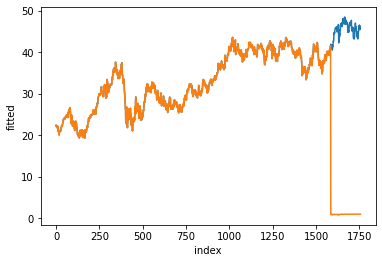

In [65]:
sns.lineplot(data=d,x='index',y='original')
sns.lineplot(data=d,x='index',y='fitted')